# Women's voices before and after #MeToo

## Introduction
In this project, we will use the [Quotebank dataset](#https://dl.acm.org/doi/pdf/10.1145/3437963.3441760), an open corpus of 178 million quotations attributed to the speakers who uttered them, extracted from 162 million English news articles published between 2008 and 2020. We will here restrict our analysis to articles published between 2015 and 2020.


## Preprocessing
We are provided with one dataset per year, which are pretty large (from 792,3Mo to 4,84Go). The datasets provided to us follow the pattern below: 

```
root
 |-- quoteID: string 
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- date: string 
 |-- numOccurrences: int
 |-- probas: list
 |-- urls: list
 |-- phase: string 
```

1. Since our analysis will be based on the difference between male and female speakers, we need to keep only the quotations for which the speakers are known. We therefore dropped the quotations for which the speaker is unknown, and made the choice to keep only the quotations for which the probability that it is the correct speaker is greater than 0.7.


2. To further reduce the datasets, we removed columns of no interest to our analysis: urls, probas, phase and quoteID. We kept the date columns only for the 2017 and 2018 datasets (years close to the #MeToo event). For other years, knowing only the year will be sufficient for our analysis. Steps 1 and 2 were performed using Google colab. 
The code for these two first steps is available [here](src/Reduce_data.ipynb).


3. Next, in order to have useful information about the speakers, we used additional speaker metadata available for ~9M unique Wikidata entities (identified by their QID) in the form of a .parquet file named speaker_attributes.parquet. We decided to keep the following attributes: 'gender', 'date_of_birth', 'occupation', 'id', 'ethnic_group', 'academic_degree', 'occupation' and 'religion'. For each dataset, we computed the current age of the speaker at the time of the quotation, and thus transformed the column 'date_of_birth' by a column 'age'. Thus, after merging, the datasets follow the following pattern:
```
root
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- numOccurrences: int
 |-- gender: ndarray
 |-- age: int
 |-- occupation: ndarray
 |-- ethnic_group: ndarray
 |-- academic_degree: ndarray
 |-- religion: ndarray
```


4. Then, we will drop the quotations for which the gender is not known, since we will build all our analyses on it. We will then replace all the wikicodes in the dataset with readable information, using a [dictionnary](data/wikidata_labels_descriptions_quotebank.csv.bz2) linking wikidata labels and descriptions. The speakers for which the year of birth is not known are also removed. 

The code for step 3 and 4 is available [here](src/get_attributes.ipynb)

## Imports

In [1]:
import pandas as pd
import bz2
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

## Datasets

In [2]:
DATA_FOLDER = 'data/'


DATA_2015 = DATA_FOLDER+"sample-2015.json.bz2"
DATA_2016 = DATA_FOLDER+"sample-2016.json.bz2"

DATA_2018 = DATA_FOLDER+"sample-2018.json.bz2"
DATA_2019 = DATA_FOLDER+"sample-2019.json.bz2"
DATA_2020 = DATA_FOLDER+"sample-2020.json.bz2"


## Wikidata attributes and dictionnary

In [3]:
WIKIDATA_LABELS = DATA_FOLDER + "wikidata_labels_descriptions_quotebank.csv.bz2"
SPEAKER_ATTRIBUTES_DATA = DATA_FOLDER+"speaker_attributes.parquet"

Load the data:

In [4]:
wiki_labels = pd.read_csv(WIKIDATA_LABELS, compression='bz2', index_col='QID')

In [5]:
quotes_2020 = pd.read_json(DATA_2020)

In [6]:
quotes_2020.head()

,quotation,speaker,qids,numOccurrences,gender,age,occupation,ethnic_group,academic_degree,religion
0,The job of the church organist is to help the ...,Donald Kennedy,Q1240022,1,male,89,"[biologist, teacher, writer, academic]",None,[Doctor of Philosophy],None
1,The only reason we come out to enforce the law...,Chris Tang,Q19646427,1,male,63,"[academic, economist]",None,None,None
2,We remain in the `contain' phase of the outbre...,Boris Johnson,Q180589,1,male,56,"[journalist, politician, editor, writer, essay...",[White British],None,[Anglicanism]
3,Egypt is the biggest single-point-of-failure i...,Sunil Tagare,Q7640351,1,male,60,None,None,None,None
4,I remember writing a petition to pray to St Th...,Peter Wood,Q19518683,1,male,74,[Australian rules football player],None,None,None


In [7]:
#Group the data by gender
speaker_grouped = quotes_2020.groupby(quotes_2020.gender)

In [8]:
speaker_grouped.numOccurrences.count()

gender
cisgender female          5
cisgender male            3
female                18368
genderfluid              23
genderqueer               2
intersex                  1
male                  81427
non-binary               66
shemale                   4
transgender female       89
transgender male         11
Name: numOccurrences, dtype: int64

In [9]:
#Keep only the 2 most represented gender and group the other in "others"
major_gender = speaker_grouped.speaker.count().sort_values(ascending = False)[0:2]
others = speaker_grouped.speaker.count().sort_values(ascending = False)[2:]

In [10]:
#Create a new serie for the barplot
other_group = pd.Series([others.values.sum()], index=['Others'])
major_gender_and_others = major_gender.append(other_group)

In [11]:
major_gender_and_others

male      81427
female    18368
Others      204
dtype: int64

##TODO: try to label with 'Male' and 'Female' (il fait wtf la il devrait les mettre je comprends pas ce qu'il fout...) 

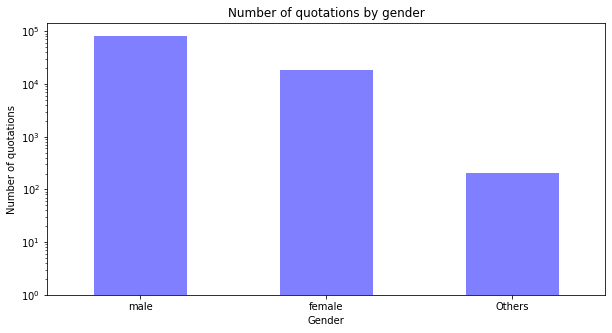

In [12]:
pl = major_gender_and_others.plot(kind="bar", x=major_gender_and_others.index, y=major_gender_and_others.values, figsize=(10, 5), log=True, \
                        alpha=0.5, rot=0, color="blue")
pl.set_xlabel("Gender")
pl.set_ylabel("Number of quotations")
pl.set_title("Number of quotations by gender");

**Be careful, this plot has log scale in y-axis.**


We see that there is only a few citations linked to speaker with gender other than 'male' or 'female'. For this reason, we will focus only on male and female gender, in order to examine the differences between them.

In [13]:
#Drop the rows having a gender other than the 2 most represented
df_MF = quotes_2020.drop(quotes_2020[
        quotes_2020['gender'].isin(major_gender.index) == False].index, inplace = False)

In [14]:
df_MF.shape[0]

99795

In [15]:
#Group again by gender, now that only 2 groups remains
gender_groups = df_MF.groupby(df_MF.gender)

In [16]:
#Count the number of occurences by gender (quotations*occurences)
citations_by_gender = gender_groups.numOccurrences.sum().sort_values(ascending = False)
citations_by_gender

gender
male      270685
female     62856
Name: numOccurrences, dtype: int64

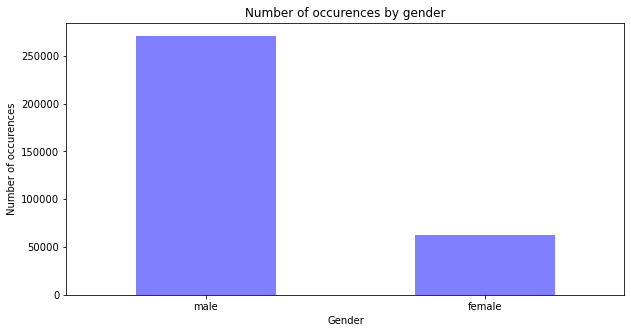

In [17]:
pl = citations_by_gender.plot(kind="bar", x=citations_by_gender.index, y=citations_by_gender.values, figsize=(10, 5), log=False, \
                        alpha=0.5, rot=0,color="blue")
pl.set_xlabel("Gender")
pl.set_ylabel("Number of occurences")
pl.set_title('Number of occurences by gender');

In [18]:
#GroupBy qids in order to get unique speakers. We add gender in the groupBy, but since we already assigned one 
#gender per speaker, it is just to provide the information in the indexing. 
unique_speaker = df_MF.groupby(['qids','gender']).mean()

In [19]:
#Let's check that the speakers are unique. 
unique_speaker.index.is_unique

True

In [20]:
print('There are', speaker_grouped.ngroups, 'unique speakers in this dataset.')

There are 11 unique speakers in this dataset.


In [21]:
#Extract the list of genders among the unique speakers
unique_speaker_gender = unique_speaker.index.to_list()

In [22]:
#Count the number of male speakers, and the number of female speakers
speaker_HF = Counter([x[1] for x in unique_speaker_gender])

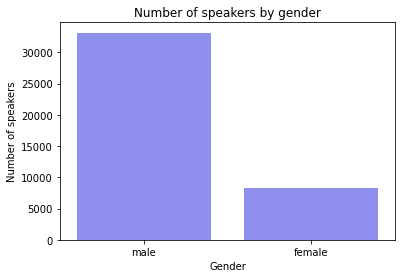

In [23]:
ax = sns.barplot(x=list(speaker_HF.keys()), y=list(speaker_HF.values()),alpha=0.5,color="blue")
plt.title('Number of speakers by gender');
plt.ylabel('Number of speakers');
plt.xlabel('Gender');